## Detection of Country Flag from images

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense,Conv2D,MaxPooling2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16

from keras.constraints import maxnorm

import tensorflow.keras as keras
import numpy as np
from tensorflow.keras.preprocessing import image



In [ ]:
pip install keras-tuner --upgrade

     |████████████████████████████████| 98 kB 3.1 MB/s 


In [ ]:
import keras_tuner as kt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
#os.getcwd()
os.chdir('/content/drive/My Drive')
os.getcwd()

'/content/drive/My Drive'

In [ ]:
# Define the search space
def create_model(hp):
  inputs = keras.Input(shape=(224,224,3))
  x = inputs
  model = Sequential()
  
  for i in range(hp.Int("cnn layers",1,4)):
    model.add(Conv2D(
        hp.Int(f"filters_{i}", 32, 128, step=32),
        kernel_size=hp.Int("kernel_size_" + str(i), 3, 5),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2,2)))
  # check if dropout layer is needed
  if hp.Boolean("dropout"):
    model.add(Dropout(0.25))
  
  model.add(Flatten())

  for j in range(hp.Int("dense layers",1,4)):
     model.add(Dense(units=hp.Int(f"dense layer_{j}", min_value=32, max_value=128, step=16), activation='relu'))
     
  model.add(Dense(units=10, activation='softmax'))

  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [ ]:
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [ ]:
model=create_model(kt.HyperParameters())

In [ ]:
tuner_search = RandomSearch(hypermodel=create_model,objective='val_accuracy',max_trials=8,overwrite=True,directory='Kerasout', project_name="Flags")

In [ ]:
## data importing  scaling, creating additional images using shear, zoom, and flip

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, rotation_range=30, validation_split=0.2, vertical_flip=True)

In [ ]:
## Importing training data
train_set = train_datagen.flow_from_directory('Flags/',target_size=(224, 224),class_mode='categorical', subset='training')

Found 1792 images belonging to 10 classes.


In [ ]:
train_set.class_indices  # identify the classes 

{'Canada': 0,
 'France': 1,
 'Germany': 2,
 'India': 3,
 'Italy': 4,
 'Russia': 5,
 'Spain': 6,
 'Switzerland': 7,
 'UK': 8,
 'USA': 9}

In [ ]:
labels = ['Canada', 'France', 'Germany', 'India', 'Italy', 'Russia','Spain', 'Switzerland', 'UK', 'USA']

In [ ]:
## Importng test data
test_set = train_datagen.flow_from_directory('Flags/',target_size=(224, 224),class_mode='categorical',subset='validation')

Found 445 images belonging to 10 classes.


In [ ]:
tuner_search.search(train_set,epochs=10,validation_data=test_set)

Trial 8 Complete [00h 08m 29s]
val_accuracy: 0.6966292262077332

Best val_accuracy So Far: 0.71685391664505
Total elapsed time: 01h 25m 07s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner_search.results_summary()

Results summary
Results in Kerasout/Flags
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
cnn layers: 3
filters_0: 32
kernel_size_0: 4
dropout: True
dense layers: 1
dense layer_0: 80
dense layer_1: 80
dense layer_2: 64
dense layer_3: 128
filters_1: 32
kernel_size_1: 3
filters_2: 32
kernel_size_2: 3
Score: 0.71685391664505
Trial summary
Hyperparameters:
cnn layers: 1
filters_0: 64
kernel_size_0: 3
dropout: False
dense layers: 1
dense layer_0: 112
dense layer_1: 112
dense layer_2: 128
dense layer_3: 64
filters_1: 128
kernel_size_1: 4
filters_2: 96
kernel_size_2: 5
Score: 0.7011235952377319
Trial summary
Hyperparameters:
cnn layers: 4
filters_0: 96
kernel_size_0: 3
dropout: False
dense layers: 2
dense layer_0: 32
dense layer_1: 128
dense layer_2: 48
dense layer_3: 32
filters_1: 64
kernel_size_1: 3
filters_2: 64
kernel_size_2: 4
filters_3: 32
kernel_size_3: 3
Score: 0.6988763809204102
Trial summary
Hyperparameters:
cnn layers: 3
filters

In [ ]:
models = tuner_search.get_best_models(num_models=2)
best_model = models[0]

In [ ]:
# Retrain the best model
chkp_filepath = '/tmp/checkpoint'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=chkp_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)
best_model.fit(train_set,epochs=30,validation_data=test_set, callbacks=[model_checkpoint_callback])

Epoch 1/30
56/56 [==============================] - 52s 936ms/step - loss: 0.2678 - accuracy: 0.9118 - val_loss: 0.9091 - val_accuracy: 0.8000
Epoch 2/30
56/56 [==============================] - 44s 792ms/step - loss: 0.2604 - accuracy: 0.9146 - val_loss: 0.9851 - val_accuracy: 0.8067
Epoch 3/30
56/56 [==============================] - 43s 772ms/step - loss: 0.2432 - accuracy: 0.9275 - val_loss: 0.9381 - val_accuracy: 0.7910
Epoch 4/30
56/56 [==============================] - 43s 775ms/step - loss: 0.2801 - accuracy: 0.9146 - val_loss: 1.1441 - val_accuracy: 0.7843
Epoch 5/30
56/56 [==============================] - 43s 772ms/step - loss: 0.2903 - accuracy: 0.9074 - val_loss: 0.8446 - val_accuracy: 0.8067
Epoch 6/30
56/56 [==============================] - 43s 772ms/step - loss: 0.2393 - accuracy: 0.9157 - val_loss: 0.9585 - val_accuracy: 0.8067
Epoch 7/30
56/56 [==============================] - 43s 770ms/step - loss: 0.2485 - accuracy: 0.9202 - val_loss: 0.9756 - val_accuracy: 0.8135

In [ ]:
best_model.load_weights(chkp_filepath)

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 32)    1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 32)   0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 32)    9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 32)   0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, None, None, 32)   0

In [ ]:
best_model.save('Flagsp.h5')

In [ ]:
## prediction of single new data

test_image= image.load_img('Test Flags/USA2.jpg',target_size=(224,224))


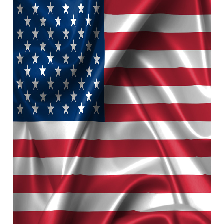

In [ ]:
test_image

In [ ]:
## Convert image to array
test_image = image.img_to_array(test_image)

In [ ]:
## For single prediction change the dimension . 

test_image=test_image.reshape(1,224,224,3)

In [ ]:
result = best_model.predict(test_image)

In [ ]:
result = result.argmax()

In [ ]:
result

8

In [ ]:
labels[result]

'UK'